**这个Notebook不需要文件夹中任何一个.py文件, 所有函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pyamg
import autograd.numpy as np
from autograd import grad

## Define Function

In [2]:
e1 = 1/5
e2 = 1/13
e3 = 1/17
e4 = 1/31
e5 = 1/65
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return 34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.sin(4*x**2*y**2)/6 + (np.sin((2*np.pi*y)/e2) + 11/10)/(6*(np.cos((2*np.pi*x)/e2) + 11/10)) + (np.cos((2*np.pi*x)/e3) + 11/10)/(6*(np.sin((2*np.pi*y)/e3) + 11/10)) + (np.sin((2*np.pi*y)/e4) + 11/10)/(6*(np.cos((2*np.pi*x)/e4) + 11/10)) + (np.cos((2*np.pi*x)/e5) + 11/10)/(6*(np.sin((2*np.pi*y)/e5) + 11/10)) + (np.sin((2*np.pi*x)/e1) + 11/10)/(6*(np.sin((2*np.pi*y)/e1) + 11/10)) + 1/6) - 3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*((4*x*y**2*np.cos(4*x**2*y**2))/3 + (np.pi*np.cos((2*np.pi*x)/e1))/(3*e1*(np.sin((2*np.pi*y)/e1) + 11/10)) - (np.pi*np.sin((2*np.pi*x)/e3))/(3*e3*(np.sin((2*np.pi*y)/e3) + 11/10)) - (np.pi*np.sin((2*np.pi*x)/e5))/(3*e5*(np.sin((2*np.pi*y)/e5) + 11/10)) + (np.pi*np.sin((2*np.pi*x)/e2)*(np.sin((2*np.pi*y)/e2) + 11/10))/(3*e2*(np.cos((2*x*np.pi)/e2) + 11/10)**2) + (np.pi*np.sin((2*np.pi*x)/e4)*(np.sin((2*np.pi*y)/e4) + 11/10))/(3*e4*(np.cos((2*x*np.pi)/e4) + 11/10)**2)) - 5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*((4*x**2*y*np.cos(4*x**2*y**2))/3 + (np.pi*np.cos((2*np.pi*y)/e2))/(3*e2*(np.cos((2*np.pi*x)/e2) + 11/10)) + (np.pi*np.cos((2*np.pi*y)/e4))/(3*e4*(np.cos((2*np.pi*x)/e4) + 11/10)) - (np.pi*np.cos((2*np.pi*y)/e3)*(np.cos((2*np.pi*x)/e3) + 11/10))/(3*e3*(np.sin((2*y*np.pi)/e3) + 11/10)**2) - (np.pi*np.cos((2*np.pi*y)/e5)*(np.cos((2*np.pi*x)/e5) + 11/10))/(3*e5*(np.sin((2*y*np.pi)/e5) + 11/10)**2) - (np.pi*np.cos((2*np.pi*y)/e1)*(np.sin((2*np.pi*x)/e1) + 11/10))/(3*e1*(np.sin((2*y*np.pi)/e1) + 11/10)**2))
def a(x, y): return (1/6)*((1.1+np.sin(2*np.pi*x/e1))/(1.1+np.sin(2*np.pi*y/e1))+(1.1+np.sin(2*np.pi*y/e2))/(1.1+np.cos(2*np.pi*x/e2))+(1.1+np.cos(2*np.pi*x/e3))/(1.1+np.sin(2*np.pi*y/e3))+(1.1+np.sin(2*np.pi*y/e4))/(1.1+np.cos(2*np.pi*x/e4))+(1.1+np.cos(2*np.pi*x/e5))/(1.1+np.sin(2*np.pi*y/e5))+np.sin(4*(x**2)*(y**2))+1)

## Define R, P, Poisson, Nonlinear Poisson

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT


def Interpolation(inputsize):
    inputsize = int(inputsize)
    OUTPUT = 4*np.transpose(Restriction(inputsize))
    return OUTPUT


def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    area = 1
    [X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),
                         np.linspace(0, 1, sqrtinputsize))
    A = area*(a(X, Y).reshape([inputsize, 1]))
    Poi = Poisson(inputsize)
    for i in range(inputsize):
        Poi[i][:] = A[i]*Poi[i][:]
    OUTPUT = Poi
    return OUTPUT

## Define Multigrid

In [4]:
def Multigrid_circle(inputsize, A_A, B, P_A, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = np.matrix(P_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [5]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.linalg.inv(M)*K
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK**s,IPRAPRA),MK**s)
    radius = np.linalg.norm(C,'fro')
    return radius

def rhoAuto(INPUT):
    P = INPUT[0]
    R = INPUT[1]
    w = INPUT[2]
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.linalg.inv(M)*K
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK**s,IPRAPRA),MK**s)
    radius = np.linalg.norm(C,'fro')
    return radius

## Define Optimizer

In [6]:
def optimizer_GD(inputsize, A, P, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,P,R,w,s)
    INPUT = [P,R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    P -= learning_rate*delta[0]
    R -= learning_rate*delta[1]
    w -= learning_rate*delta[2]
    rhonew = rho(inputsize,A,P,R,w,s)
    return P, R, w, rhoold, rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, P, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,P,R,w,s)
    L = step_length
    while L < 1:
        M = (1-L)*A0 + L*A1
        Pnew, Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, P, R, w, s, learning_rate)
        if rhonew > accept_radius:
            M = M + L*A0 - L*A1
            step_length = 0.1*step_length
            M = (1-L)*A0 + L*A1
            print('Decrease the step_length and try again!!')
            print("rho = {}".format(rhonew))
            print("===================")
        else:
            P = Pnew
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    Rhonew = rhonew
    return P, R, w, Rhoold, Rhonew

## GMM

In [7]:
finegridsize = 6
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize+1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = Interpolation(inputsize)
s = 2
w=2/3
NUM_EPOCH = 10


**Calculate Result and Residual**

In [8]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, P, R, s, w, 40)

Residual = 29.92683539031339
Interation = 0
Residual = 3.907522186129551
Interation = 1
Residual = 0.729410298919665
Interation = 2
Residual = 0.1553254731887576
Interation = 3
Residual = 0.035633516024290296
Interation = 4
Residual = 0.008608135206512444
Interation = 5
Residual = 0.0021618231820417907
Interation = 6
Residual = 0.0005595312037292345
Interation = 7
Residual = 0.0001483205983951562
Interation = 8
Residual = 4.0086441198760105e-05
Interation = 9
Residual = 1.1010579466193627e-05
Interation = 10
Residual = 3.066230185901172e-06
Interation = 11
Residual = 8.641239538017301e-07
Interation = 12
Residual = 2.4607043639937945e-07
Interation = 13
Residual = 7.070997841911484e-08
Interation = 14
Residual = 2.0480054173789915e-08
Interation = 15
Residual = 5.972495385114369e-09
Interation = 16
Residual = 1.7520725827290048e-09
Interation = 17
Residual = 5.166125374331868e-10
Interation = 18
Residual = 1.529950928728483e-10
Interation = 19
Residual = 4.5481470799535406e-11
Interati

**Plot Result**

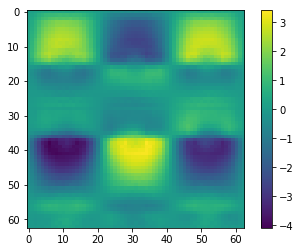

In [9]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

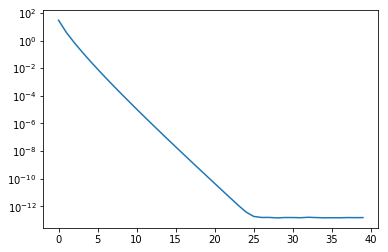

In [10]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [11]:
GMM_rho = rho(inputsize,A1,P,R,w,s)
print(GMM_rho)

4.850005147161799


## DMM

**Optimize R, P, $\omega$**

In [ ]:
Pnew, Rnew, wnew, Rhoold, Rhonew = homotopy_optimizer_GD(inputsize, A0, A1, P, R, w, s, learning_rate = 1e-5 ,accept_radius = GMM_rho,step_length = 1e-4)

L = 0.0002
rho = 0.6961108233646985
L = 0.00030000000000000003
rho = 0.6923048539946061
L = 0.0004
rho = 0.6886817079054247
L = 0.0005
rho = 0.6851850808000954
L = 0.0006000000000000001
rho = 0.6817881532039248
L = 0.0007000000000000001
rho = 0.6784749497248592
L = 0.0008000000000000001
rho = 0.6752347320081866
L = 0.0009000000000000002
rho = 0.672059709637982
L = 0.0010000000000000002
rho = 0.6689439264967233
L = 0.0011000000000000003
rho = 0.6658826517629023
L = 0.0012000000000000003
rho = 0.6628720175506878
L = 0.0013000000000000004
rho = 0.6599087890622166
L = 0.0014000000000000004
rho = 0.6569902112912147
L = 0.0015000000000000005
rho = 0.654113902568145
L = 0.0016000000000000005
rho = 0.6512777781398233
L = 0.0017000000000000006
rho = 0.6484799937683142
L = 0.0018000000000000006
rho = 0.6457189031163257
L = 0.0019000000000000006
rho = 0.6429930248950503
L = 0.0020000000000000005
rho = 0.6403010170929927
L = 0.0021000000000000003
rho = 0.6376416564494748
L = 0.0022
rho = 0.6350138

**Calculate Result and Residual**

In [ ]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A, RightF, Pnew, Rnew, s, wnew, 40)

**Plot Result**

In [ ]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

In [ ]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [ ]:
DMM_radius = Rhonew
print(Rhonew)

## Compare

In [ ]:
print('GMM_rho = {}'.format(GMM_rho))
print('DMM_rho = {}'.format(Rhonew))


In [ ]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'DMM_Res')
plt.legend(loc='upper right')

## R, P and  $\omega$ after Optimization

In [ ]:
print('omega after optimization = {}'.format(wnew))

In [ ]:
print('P after optimization ')
plt.imshow(np.log10(np.abs(Pnew)))
plt.colorbar()

In [ ]:
print('R after optimization ')
plt.imshow(np.log10(np.abs(Rnew)))
plt.colorbar()

In [ ]:
print("P under log10(abs())")
plt.plot(np.log10(np.abs(Pnew))[round(0.5*inputsize)][:])

In [ ]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[:][round(0.5*outputsize)])